<a href="https://colab.research.google.com/github/DanieleAngioni97/ML_Project/blob/master/Autoencoders_cifar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!git clone https://github.com/DanieleAngioni97/ML_Project.git

Cloning into 'ML_Project'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
fatal: not a git repository (or any of the parent directories): .git


In [25]:
%cd /content/ML_Project

/content/ML_Project


In [26]:
!git pull

Already up to date.


In [34]:
!git push

fatal: could not read Username for 'https://github.com': No such device or address


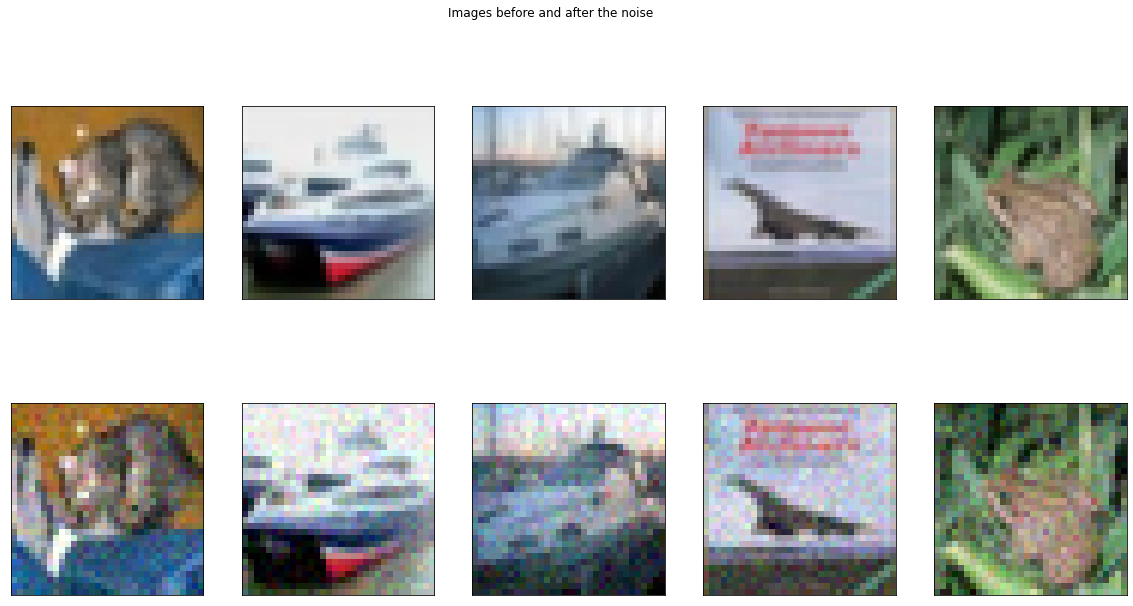

In [28]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np

(x_train, _), (x_test, _) = cifar10.load_data()
 
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 32, 32, 3))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 32, 32, 3))  # adapt this if using `channels_first` image data format
 
noise_factor = 0.05
#loc and scale being mean and std
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
 
#clip pixel under 0 and above 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
 
n = 5
bias = 0
plt.figure(figsize=(20, 10))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    ax = plt.subplot(2, n, n+i+1)
    plt.imshow(x_test_noisy[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [29]:
from keras.layers import Input, Conv2D, AveragePooling2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import MeanSquaredError

def create_autoencoder():
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------
    #                       DEFINE AUTOENCODER ARCHITECTURE
    #---------------------------------------------------------------------------
    #---------------------------------------------------------------------------

    input_img = Input(shape=(32, 32, 3))
 
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x) #16x16
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = AveragePooling2D((2, 2), padding='same')(x)   #4x4
    encoded = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
 
    # at this point the representation is (4, 4, 128)
 
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x) #8x8
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #16x16
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x) #32x32
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
 
    autoencoder = Model(input_img, decoded)
    
    return autoencoder

In [32]:
#Set this if you want to start training from a pretrained autoencoder
pretrained = False
pretrained_autoencoder = "autoencoderCifar8.h5"

#Set a drive folder to save models in it (make sure you mounted before)
path = "/content/drive/My Drive/Colab_Notebooks/ML_Project/models_saved/"

#Set save to True if you want to save the model every "save_step" epochs
#Set False instead if you want to supervise the training process and stop it
#whenever you like
save = False  
save_step = 5

n_epochs = 300

autoencoder = create_autoencoder()  #create the architecture

if pretrained:
    autoencoder.load_weights(pretrained_autoencoder)
 
optim = Adam(learning_rate=0.001)
loss = MeanSquaredError()
autoencoder.compile(optimizer=optim, loss=loss, metrics=['acc'])

f_loss=open(path + "loss.txt", "a+")
f_val_loss=open(path + "val_loss.txt", "a+")
f_acc=open(path + "acc.txt", "a+")
f_val_acc=open(path + "val_acc.txt", "a+")

for i in range(n_epochs):
    print("\n%%-------EPOCH # {} --------%%".format(i)) 
    history = autoencoder.fit(x_train_noisy, x_train,
                    epochs=1,
                    batch_size=128,
                    shuffle=True,
                    verbose=1,
                    validation_data=(x_test_noisy, x_test))

    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if save:
        f_acc.write(str(acc[0])+ ' ')
        f_val_acc.write(str(val_acc[0])+ ' ')
        f_loss.write(str(loss[0])+ ' ')
        f_val_loss.write(str(val_loss[0])+ ' ')

        if i%save_step == 0:
                if i<10:
                    autoencoder.save_weights(path + "autoencoderCifar_00" + str(i) + ".h5")
                elif i<100:
                    autoencoder.save_weights(path + "autoencoderCifar_0" + str(i) + ".h5")
                else:
                    autoencoder.save_weights(path + "autoencoderCifar_" + str(i) + ".h5")

f_acc.close()
f_val_acc.close()
f_loss.close()
f_val_loss.close()


%%-------EPOCH # 0 --------%%
Train on 50000 samples, validate on 10000 samples
Epoch 1/1
45952/50000 [==========================>...] - ETA: 1s - loss: 0.0257 - acc: 0.4605

KeyboardInterrupt: ignored

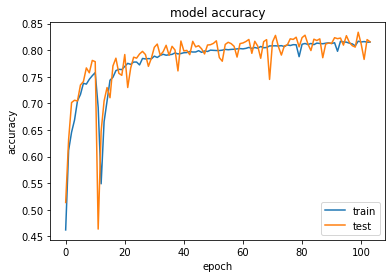

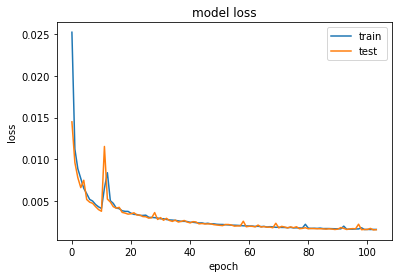

In [33]:
acc = open(path + "acc.txt", "r").read()
loss = open(path + "loss.txt", "r").read()
val_acc = open(path + "val_acc.txt", "r").read()
val_loss = open(path + "val_loss.txt", "r").read()

acc = list(acc[:-1].split(" "))
loss = list(loss[:-1].split(" "))
val_acc = list(val_acc[:-1].split(" "))
val_loss = list(val_loss[:-1].split(" "))

acc = np.array(acc, dtype=np.float32)
loss = np.array(loss, dtype=np.float32)
val_acc = np.array(val_acc, dtype=np.float32)
val_loss = np.array(val_loss, dtype=np.float32)

# summarize history for accuracy
plt.figure()
plt.plot(list(acc))
plt.plot(list(val_acc))
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.savefig(path + 'accuracy.png')
plt.show()


#summarize history for loss
plt.figure()
plt.plot(list(loss))
plt.plot(list(val_loss))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig(path + 'loss.png')
plt.show()



### **Run this cell to save the model after training (used when save=False)**

In [ ]:
#Set the path
# path = "/content/drive/My Drive/Colab_Notebooks/ML_Project/models_to_be_saved/"

autoencoder.save_weights(path + "autoencoderCifar_Start" + ".h5")

# **Start here if you only want to evaluate the pretrained model**

In [ ]:
from keras.models import load_model

path = "/content/drive/My Drive/Colab_Notebooks/ML_Project/models_saved/"
model_name = "autoencoderCifar_100.h5"
 
autoencoder = create_autoencoder()
autoencoder.load_weights(path + model_name)

### **Evaluate the selected model**

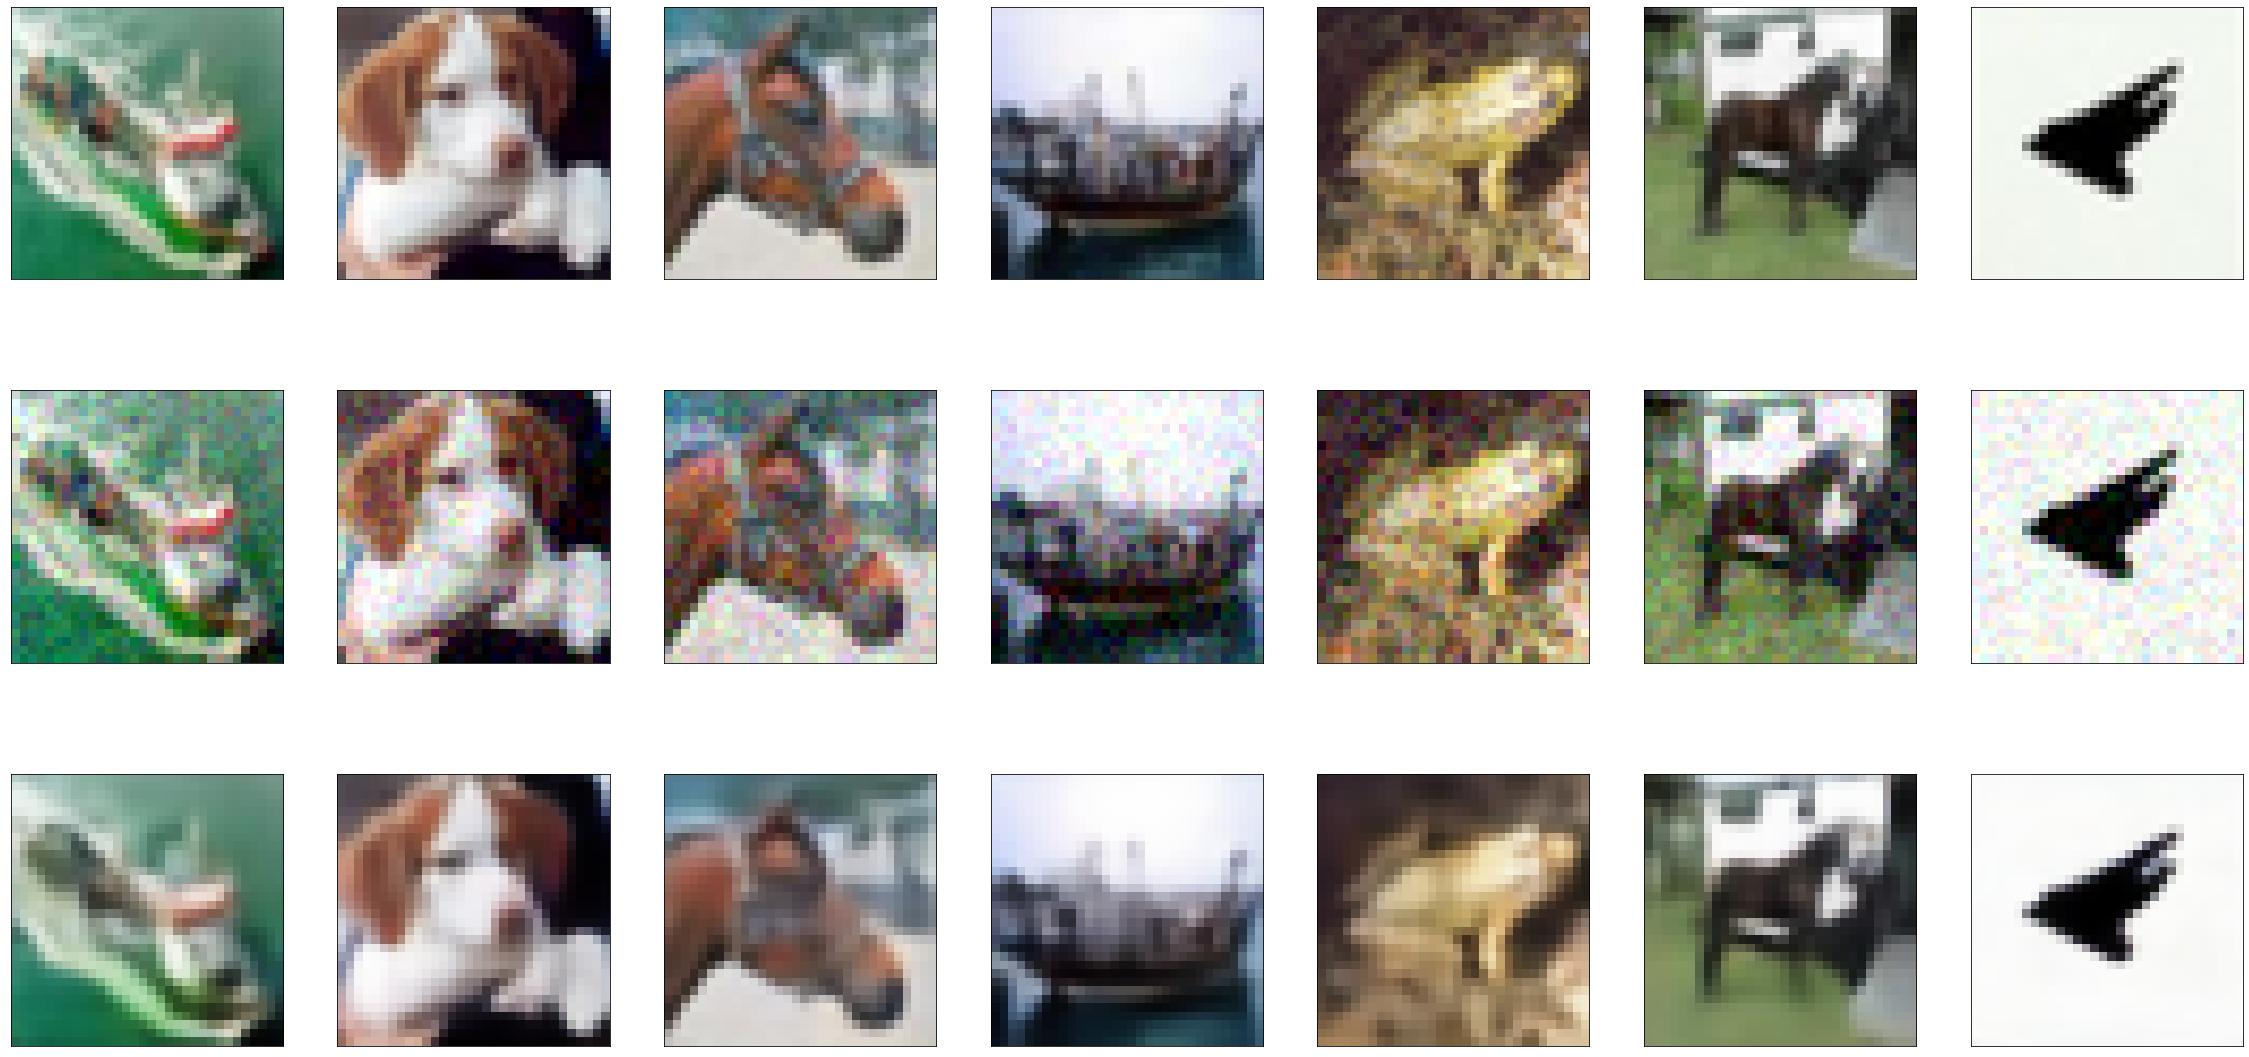

In [ ]:
n = 7
bias = 15
plt.figure(figsize=(40, 20))
 
# x_test_noisy = x_test + 0.05 * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)
decoded_imgs = autoencoder.predict(x_test[bias:bias+n])
 
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display corrupted
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i+bias].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
 
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### **Improovements during training**

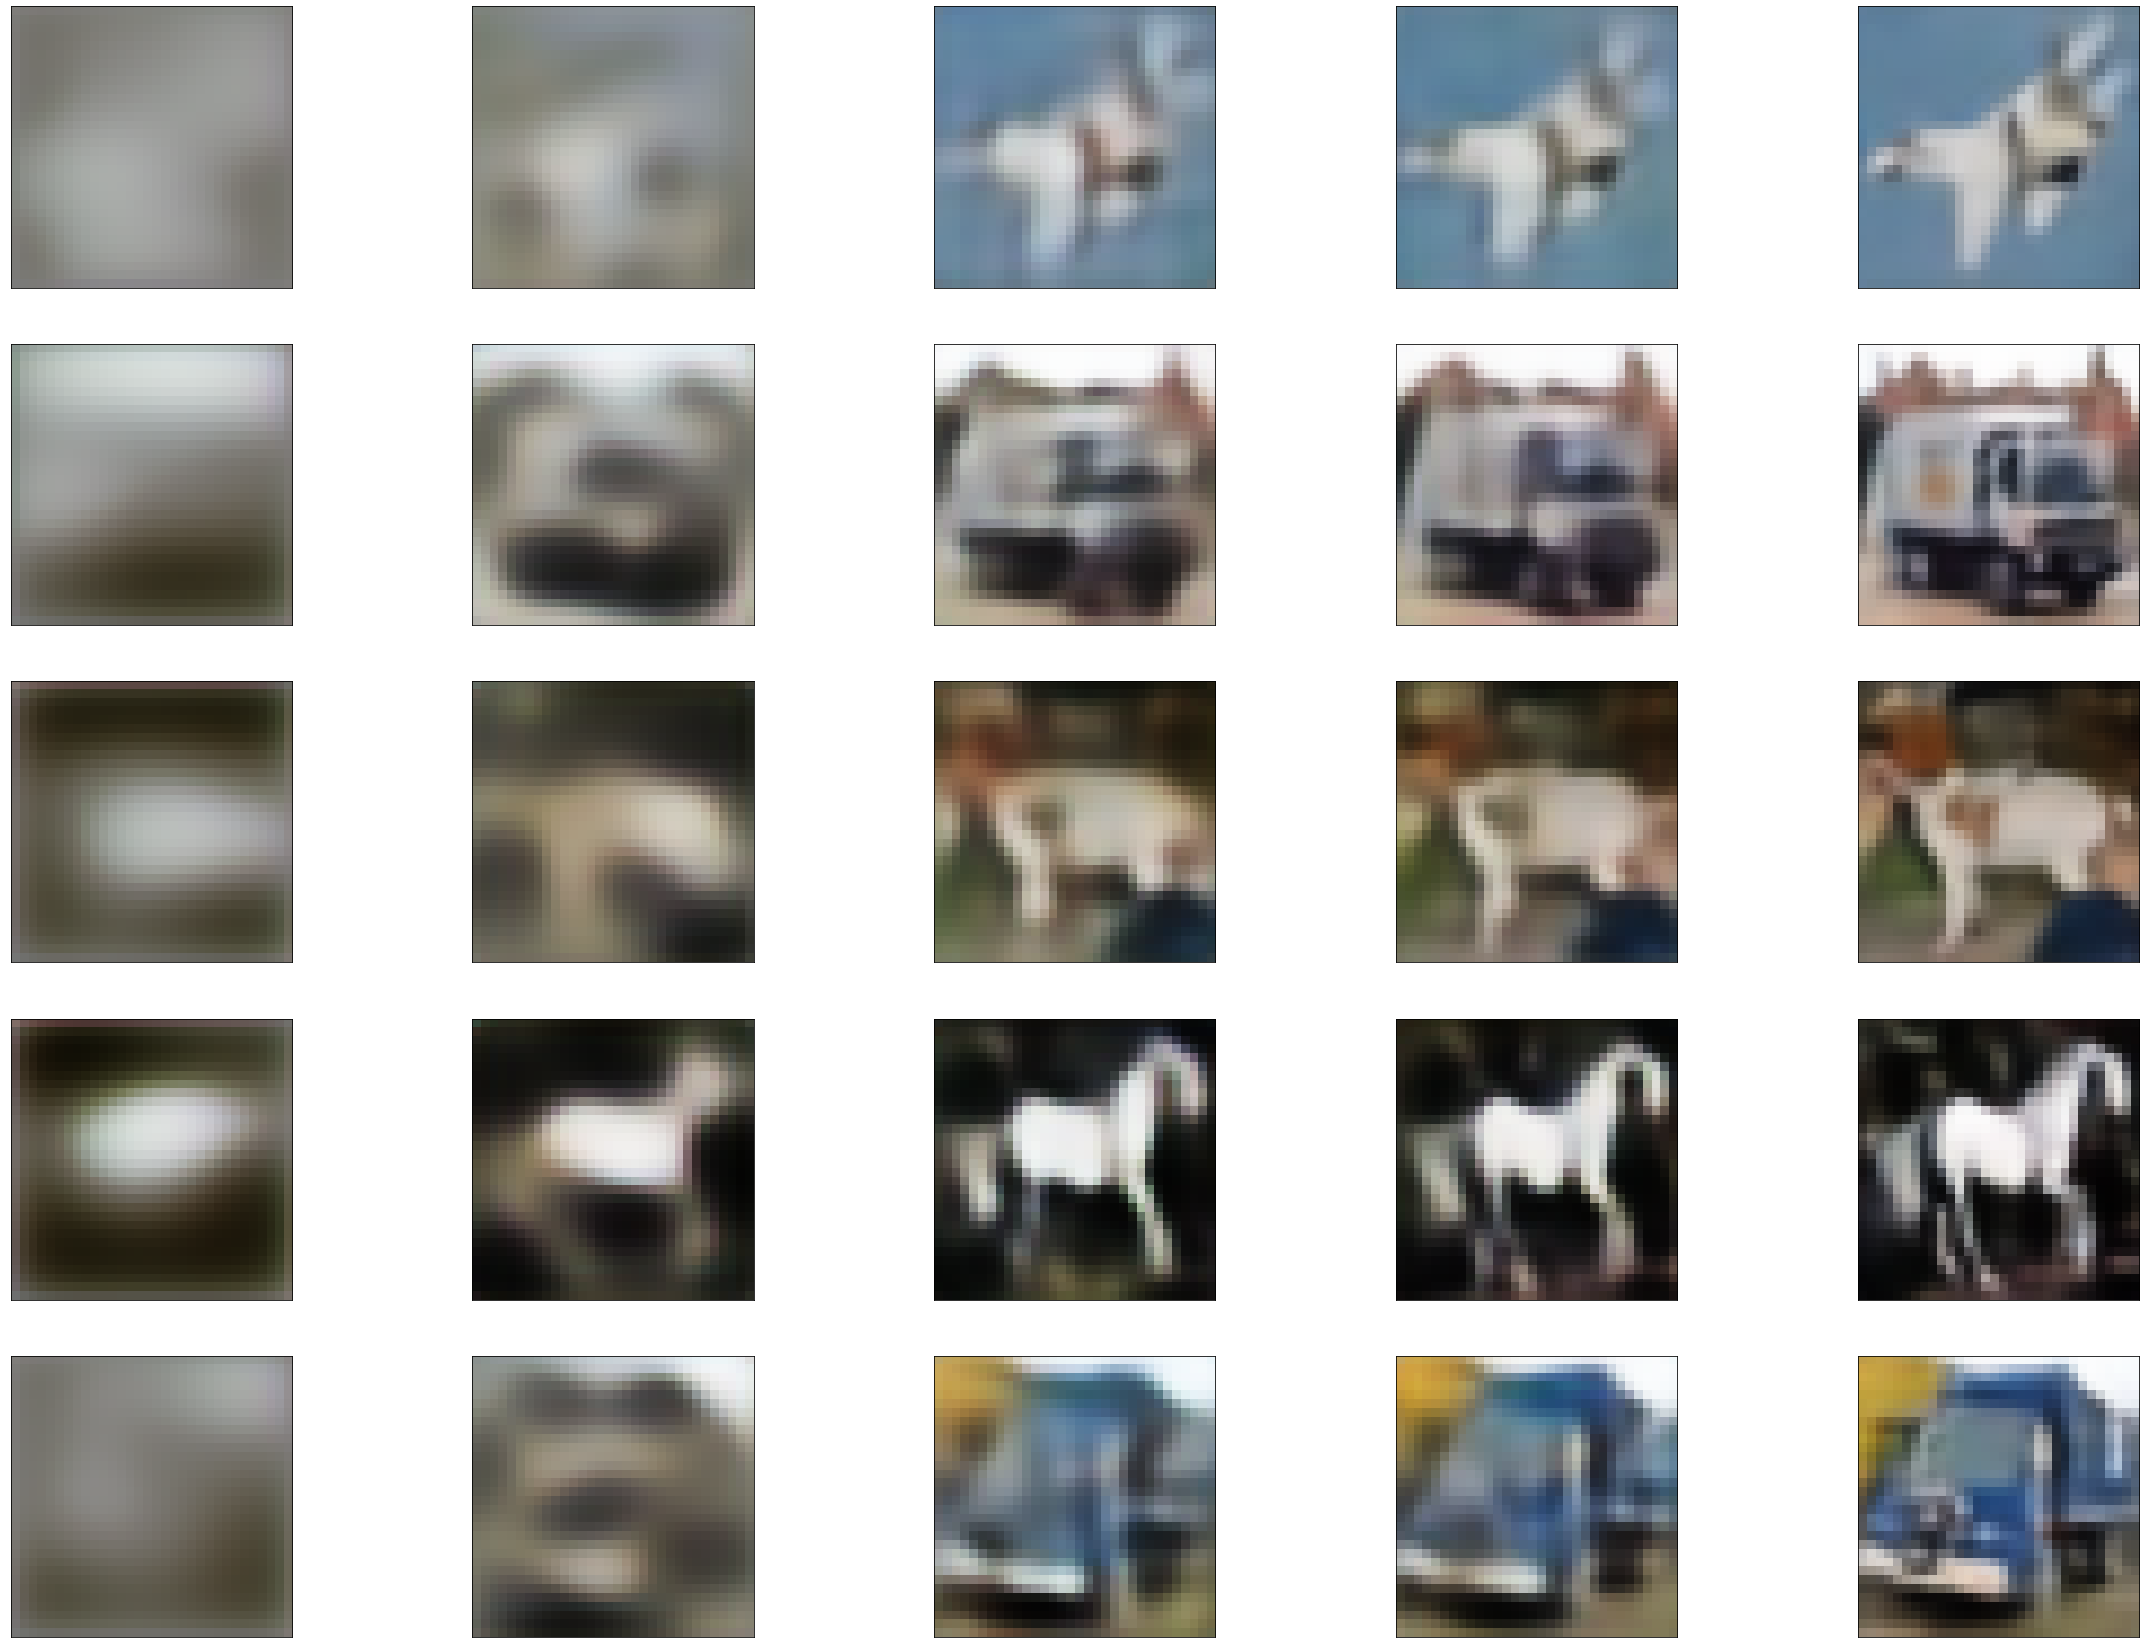

In [ ]:
def plot_improovements(n_images, bias, model_list, figsize = (20,40)):
    path = "/content/drive/My Drive/Colab_Notebooks/ML_Project/models_saved/"

    n_images = 5
    bias = 10
    n_improovements = len(model_list)
    plt.figure(figsize = figsize)

    for i, model in enumerate(model_list):
        autoencoder.load_weights(path + model)
        decoded_imgs = autoencoder.predict(x_test_noisy[bias:bias+n])
        for j in range(n_images):
            # display reconstruction
            ax = plt.subplot(n_images, n_improovements, i + 1 + j*n_improovements)
            plt.imshow(decoded_imgs[j].reshape(32, 32, 3))
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

#Check first file names in the drive
model_list = ["autoencoderCifar_Start.h5",
              "autoencoderCifar_000.h5",
              "autoencoderCifar_005.h5",
              "autoencoderCifar_010.h5",
              "autoencoderCifar_100.h5"]

plot_improovements(n_images = 10, bias = 10, model_list = model_list, 
                   figsize = (40,30))